In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import scipy.stats
import pybedtools
import pickle
from pyfaidx import Fasta
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import glob

# from seq2atac.stable import compute_gc_bed, one_hot_encode, read_pickle, compute_signal, write_pickle
from seq2atac.analysis import get_promoterai_tss, get_cosmic_pancan_genes
# from seq2atac.analysis.enrichment_utils import create_pancancer_distribution_plots, create_pancancer_correlations, create_pancancer_valuecounts, create_pancancer_distribution_plots_discrete
# from seq2atac.analysis.sample_controls import matching_logic
from seq2atac.analysis.mutation_utils import compute_vierstra_groups, compute_trinuc, ingene_indicator
# from seq2atac.analysis.mutation_processing_pipeline_utils import annotateNearestGene, annotateScore, filterannotatePeaks, annotatePhylopScore, annotatePhylopScorePeak, annotateBedfile

import sys
sys.path.append('~/project')
from reg_diffs.scripts import evalism_v22 as evalism
from reg_diffs.scripts.analysis import motif_enrichment_cmp as mtfcmp
from reg_diffs.scripts.analysis import cancervcontrol_nearpancan as cancvctrlpan

In [2]:
export = True

In [7]:
# create peaksets df
split_on='_cnvcrct'
disease_files = '~/tmp/results/*_cnvcrctv5_gt100_promoterpknorm.csv'

df_d = pd.DataFrame()
disease_files = glob.glob(disease_files)
for f in disease_files:
    sample = os.path.split(f)[1].split(split_on)[0]
    dt = pd.read_csv(f, index_col=0)
    dt['sample'] = sample
    df_d = pd.concat([df_d, dt])
df_d['peak'] = df_d.index.to_list()
# 
# create peak sets
# try making NaN not-differential
pks = {}
df_ = df_d.copy()

for s in df_['sample'].unique():
    dt = df_.loc[df_['sample']==s]
    pks[s] = {'up': list(set(dt.loc[(dt['type']=='up-regulated'), 'peak'])),
                    'do': list(set(dt.loc[(dt['type']=='do-regulated') , 'peak'])),
                    'not': list(set(dt.loc[(dt['type']=='not-differential'), 'peak']))}

In [10]:
export = True

In [11]:
# export
file = '~/tmp/data/diffpks_indbrcavctfl_cnvcrctv6_gt100_union_promoternorm.pkl'
if export:
    
    with open(file, 'wb') as f:
        pickle.dump(pks, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
else:
    with open(file, 'rb') as f:
        pks = pickle.load(f)
        f.close()


# show pk numbers

In [12]:
for k,v in pks.items():
    print(k, '...')
    print('  up:', len(set(v['up'])))
    print('  do:', len(set(v['do'])))
    print('  not:', len(set(v['not'])))
    print('')

LumA_2 ...
  up: 48265
  do: 20513
  not: 437459

BASAL5 ...
  up: 22637
  do: 8654
  not: 474946

LumB_4 ...
  up: 38069
  do: 36749
  not: 431419

LumA_3 ...
  up: 55161
  do: 33189
  not: 417887

HER2_2 ...
  up: 36833
  do: 52590
  not: 416814

BASAL4 ...
  up: 38803
  do: 35694
  not: 431740

BASAL3 ...
  up: 50760
  do: 38423
  not: 417054

HER2_1 ...
  up: 60992
  do: 38943
  not: 406302

HER2_1a ...
  up: 52215
  do: 47738
  not: 406284

LumA_1 ...
  up: 37688
  do: 14255
  not: 454294

BASAL2 ...
  up: 68790
  do: 77377
  not: 360070

BASAL1 ...
  up: 31854
  do: 63375
  not: 411008

LumB_5 ...
  up: 54087
  do: 25018
  not: 427132

HER2_3 ...
  up: 40634
  do: 17296
  not: 448307

HER2_4 ...
  up: 37903
  do: 17588
  not: 450746



In [ ]:
for k in peaksets.keys():
    dt = mtfcmp.peakset2df(peaksets[k])
    for kk in dt.keys():
        dt[kk].to_csv('~/reg_diffs/results/diffpks/indbrcavctrl_

In [13]:
# WRITE peaksets for venndiagram overlapping peaks
## get peaksets

with open(file, 'rb') as f:
    peaksets = pickle.load(f)
    f.close()

 

lum_keys = [k for k in peaksets.keys() if 'lum' in k.lower()]
basal_keys = [k for k in peaksets.keys() if 'basal' in k.lower()]
her_keys = [k for k in peaksets.keys() if 'her' in k.lower()]

pks = []
for d in ['up', 'do']:
    for k in lum_keys:
        pks += peaksets[k][d]
    pks = list(set(pks))
    pd.DataFrame(pks).to_csv('~/reg_diffs/results/overlapping_diffpks_indbrcaVctrl_cnvcrctv6_luminal_{}.csv'.format(d))
    
pks = []
for d in ['up', 'do']:
    for k in basal_keys:
        pks += peaksets[k][d]
    pks = list(set(pks))
    pd.DataFrame(pks).to_csv('~/reg_diffs/results/overlapping_diffpks_indbrcaVctrl_cnvcrctv6_basal_{}.csv'.format(d))
    
pks = []
for d in ['up', 'do']:
    for k in her_keys:
        pks += peaksets[k][d]
    pks = list(set(pks))
    pd.DataFrame(pks).to_csv('~/reg_diffs/results/overlapping_diffpks_indbrcaVctrl_cnvcrctv6_her_{}.csv'.format(d))

In [16]:
with open(file, 'rb') as f:
    pks = pickle.load(f)
    f.close()

In [14]:
# load original
orig_file = '~/tmp/data/diffpks_indbrcavctfl_cnvcrctv3_gt100_union_promoternorm.pkl'
with open(orig_file, 'rb') as f:
    pks_orig = pickle.load(f)
    f.close()


In [17]:
# create num in orig and old
pkcnt = {'sample': [], 'n_up': [], 'n_do': [], 'n_not': [], 'n_up_orig': [], 'n_do_orig': [], 'n_not_orig': []}
for k in pks.keys():
    assert k in pks_orig, 'where is that key?'
    pkcnt['sample'].append(k)
    pkcnt['n_up_orig'].append(len(pks_orig[k]['up']))
    pkcnt['n_do_orig'].append(len(pks_orig[k]['do']))
    pkcnt['n_not_orig'].append(len(pks_orig[k]['not']))
    
    pkcnt['n_up'].append(len(pks[k]['up']))
    pkcnt['n_do'].append(len(pks[k]['do']))
    pkcnt['n_not'].append(len(pks[k]['not']))

In [18]:
pkcnt = pd.DataFrame(pkcnt)
pkcnt = pkcnt.sort_values(by='sample', ascending=True)

In [19]:
pkcnt['up_new_minus_old'] = pkcnt['n_up'] - pkcnt['n_up_orig']
pkcnt['do_new_minus_old'] = pkcnt['n_do'] - pkcnt['n_do_orig']
pkcnt['not_new_minus_old'] = pkcnt['n_not'] - pkcnt['n_not_orig']

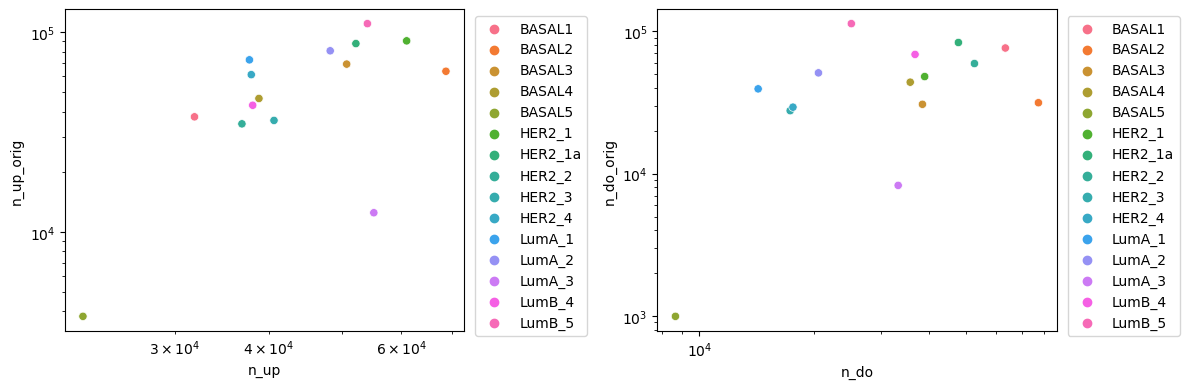

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(x='n_up', y='n_up_orig', hue='sample', data=pkcnt, ax=ax[0])
sns.scatterplot(x='n_do', y='n_do_orig', hue='sample', data=pkcnt, ax=ax[1])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
# sns.scatterplot(x='n_not', y='n_not_orig', hue='sample', data=pkcnt, ax=ax[2])
ax[0].legend(bbox_to_anchor=(1.01, 1))
ax[1].legend(bbox_to_anchor=(1.01, 1))
# ax[2].legend(bbox_to_anchor=(1.01, 1))
fig.tight_layout()

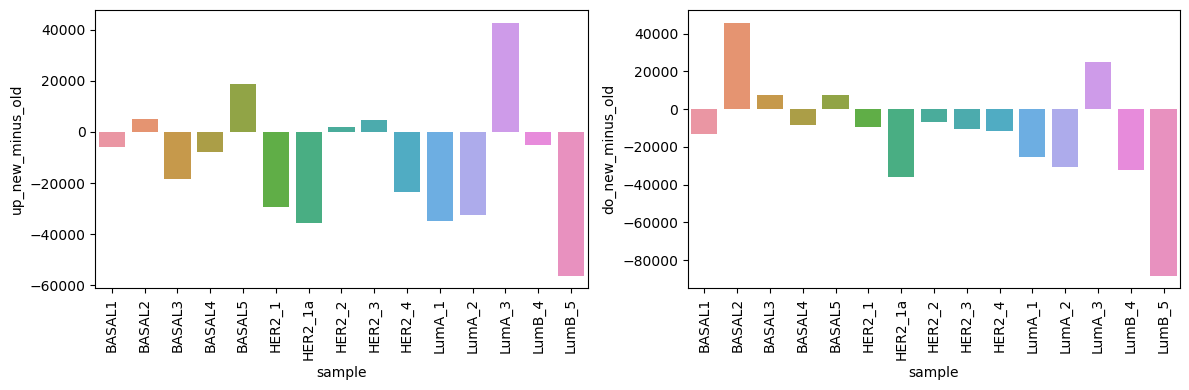

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x='sample', y='up_new_minus_old', hue='sample', data=pkcnt, ax=ax[0], dodge=False, )
sns.barplot(x='sample', y='do_new_minus_old', hue='sample', data=pkcnt, ax=ax[1], dodge=False, )
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)
fig.tight_layout()

# mtf enrichment

In [22]:
export = False

In [23]:
## test v2

upvdo_outfile = '~/tmp/results/reg_diffs/indbrcavctrl_v5_modnames_cnvcrctgt100.csv'

if export:
    df = mtfcmp.mtfcmp_indbrcavctrl_v2(
        name_key='modified_names', 
        peakset_file='~/tmp/data/differential_pk_sets_cancerVctrl_indbrca_cnvcrct_gt100_union_promoternorm.pkl', 
        outfile=upvdo_outfile,)
else:
    df = pd.read_csv(upvdo_outfile, index_col=0)


In [25]:
export = False

In [26]:
## test v2


upvdo_outfile = '~/tmp/results/reg_diffs/indbrcavctrl_v5_orignames_fixed.csv'

if export:
    df = mtfcmp.mtfcmp_indbrcavctrl_v2(
        name_key='group_name', 
        peakset_file='~/tmp/data/diffpks_indbrcavctfl_cnvcrctv5_gt100_union_promoternorm.pkl', 
        outfile=upvdo_outfile,
        include_tab=True)
else:
    df = pd.read_csv(upvdo_outfile, index_col=0)

    

# viz

In [32]:
# reload 
upvdo_outfile = '~/tmp/results/reg_diffs/indbrcavctrl_v5_orignames_fixed.csv'
df_orig = pd.read_csv(upvdo_outfile, index_col=0)


In [ ]:
# viz 

# viz doVnot

####################################################
# args
####################################################
export = True
name_key = 'group_name'
suffix = 'clstrmap_v6_orignames_nobasal5'
grid ={'zscore': ['rowcol',],
       'topn': ['sig_only_top10ORgt1', ],
       'drop': [None, ]}
subsets = {'up': df_orig.loc[[True if '_canc_cancup' in s else False for s in df_orig['sample']]],}
          # 'do': df_orig.loc[[True if 'cancdo' in s and '_canc_' not in s else False for s in df_orig['sample']]]}
# remove basal 5?
subsets['up'] = subsets['up'].loc[[True if 'BASAL5' not in s else False for s in subsets['up']['sample']]]
# subsets['do'] = subsets['do'].loc[[True if 'BASAL5' not in s else False for s in subsets['do']['sample']]]
col_cluster = False
viz_OR = True
cmap = 'hot_r'
####################################################
figsizes = {'topn_None': (10, 30),
            'topn_10': (10, 14),
            'topn_20': (10, 20),
            'topn_sig_only_top10ORlt1': (5, 12),
            'topn_sig_only_top10ORgt1': (5, 12),
            'topn_sig_only_top5OR': (5, 12),
            'topn_sig_only_top3OR': (5, 10),
            'topn_sig_only_top10OR': (5, 12)}
for n in grid['topn']:
    if 'topn_{}'.format(n) not in figsizes.keys():
        figsizes['topn_{}'.format(n)] = (5, 12) # default

pfp = os.path.join('~/project/reg_diffs/results/tmp/', datetime.datetime.now().strftime('%y%m%d'))
if not os.path.exists(pfp):
    os.makedirs(pfp)

if export:
    print('tmp folder for plots:', pfp)

count = 0
for subset in subsets.keys():
    for zscore_type in grid['zscore']:
        for n in grid['topn']:
            for drop_motif in grid['drop']:
                print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
                dfplt, p = mtfcmp.viz_mtfcmp(
                    subsets[subset], 
                    name_key=name_key, 
                    names2display=None,
                    topn=n,
                    fillna=True,
                    viz_OR=viz_OR,
                    drop=drop_motif,
                    cmap=cmap,
                    zscore=zscore_type,
                    save_plot=None if not export else os.path.join(pfp, '{}_{}_z{}_top{}_drop{}.pdf'.format(suffix, subset, zscore_type, n, drop_motif)),
                    save_mat=None if not export else '~/tmp/results/reg_diffs/{}_{}_z{}_top{}_drop{}.csv'.format(suffix, subset, zscore_type, n, drop_motif),
                    return_plot_obj=True,
                    col_cluster=col_cluster,
                    figsize_wh=figsizes['topn_{}'.format(n)],
                )
                if export:
                    dfplt['df_prez'].to_csv('~/tmp/results/reg_diffs/{}_s{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, subset, zscore_type, n, drop_motif))
                    print('  wrote prez-mat: {}'.format('~/tmp/results/reg_diffs/{}_s{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, subset, zscore_type, n, drop_motif)))
                    print('  wrote pltmat: ~/tmp/results/reg_diffs/{}_{}_z{}_top{}_drop{}.csv'.format(suffix, subset, zscore_type, n, drop_motif))
                    print('  wrote plot: {}'.format(os.path.join(pfp, '{}_{}_z{}_top{}_drop{}.pdf'.format(suffix, subset, zscore_type, n, drop_motif))))
                count+=1

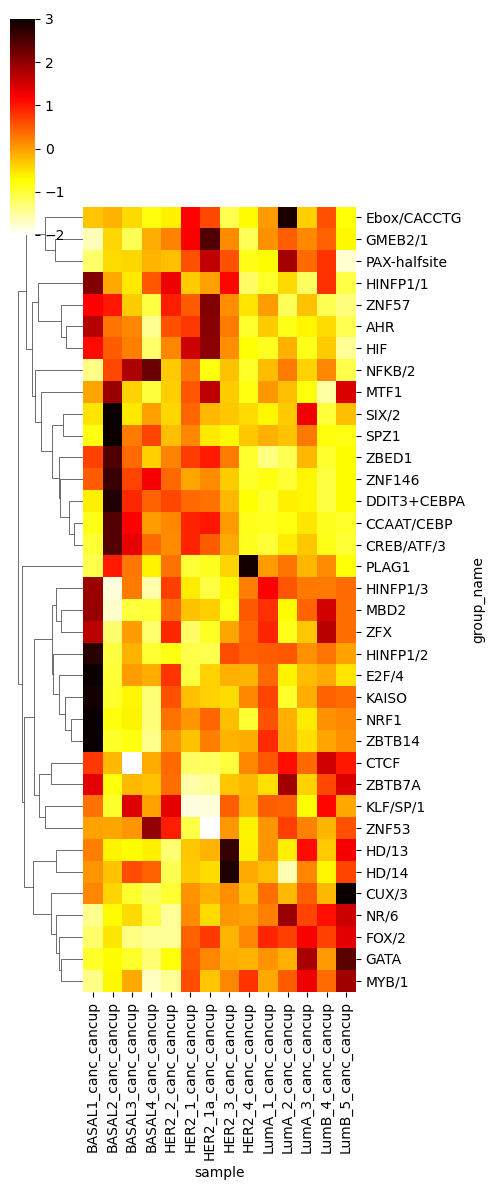

In [34]:
dt = dfplt['df_plot'][['BASAL1_canc_cancup', 'BASAL2_canc_cancup', 'BASAL3_canc_cancup',
       'BASAL4_canc_cancup', 'HER2_2_canc_cancup', 'HER2_1_canc_cancup', 'HER2_1a_canc_cancup', 'HER2_3_canc_cancup', 'HER2_4_canc_cancup',
       'LumA_1_canc_cancup', 'LumA_2_canc_cancup', 'LumA_3_canc_cancup',
       'LumB_4_canc_cancup', 'LumB_5_canc_cancup']]
p = sns.clustermap(dt, xticklabels=True, yticklabels=True, cmap=cmap, 
                   row_cluster=True, col_cluster=False, z_score=None, figsize=(5, 12), vmax=3, vmin=-2.)


In [ ]:
# save proper one 
file = '~/tmp/results/reg_diffs/{}_{}_z{}_top{}_drop{}.csv'.format(suffix, subset, zscore_type, n, drop_motif)
print('# pre-z mat:\n  {}\n#pltmat:\n  {}'.format('~/tmp/results/reg_diffs/{}_s{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, subset, zscore_type, n, drop_motif), file))
p.data2d.to_csv(file)

In [37]:
print('# order:')
print(dt.index[p.dendrogram_row.reordered_ind].to_list())
print('')
if col_cluster:
    print(dfplt['df_plot'].columns[p.dendrogram_col.reordered_ind].to_list())
else:
    print(dfplt['df_plot'].columns.to_list())

['Ebox/CACCTG', 'GMEB2/1', 'PAX-halfsite', 'HINFP1/1', 'ZNF57', 'AHR', 'HIF', 'NFKB/2', 'MTF1', 'SIX/2', 'SPZ1', 'ZBED1', 'ZNF146', 'DDIT3+CEBPA', 'CCAAT/CEBP', 'CREB/ATF/3', 'PLAG1', 'HINFP1/3', 'MBD2', 'ZFX', 'HINFP1/2', 'E2F/4', 'KAISO', 'NRF1', 'ZBTB14', 'CTCF', 'ZBTB7A', 'KLF/SP/1', 'ZNF53', 'HD/13', 'HD/14', 'CUX/3', 'NR/6', 'FOX/2', 'GATA', 'MYB/1']
['BASAL1_canc_cancup', 'BASAL2_canc_cancup', 'BASAL3_canc_cancup', 'BASAL4_canc_cancup', 'HER2_1_canc_cancup', 'HER2_1a_canc_cancup', 'HER2_2_canc_cancup', 'HER2_3_canc_cancup', 'HER2_4_canc_cancup', 'LumA_1_canc_cancup', 'LumA_2_canc_cancup', 'LumA_3_canc_cancup', 'LumB_4_canc_cancup', 'LumB_5_canc_cancup']


In [82]:
# p = sns.clustermap(dfplt['df_plot'], xticklabels=True, yticklabels=True, cmap=cmap, 
#                    row_cluster=True, col_cluster=True, z_score=None, figsize=(5, 12), vmax=2., vmin=-2.)

In [ ]:
# viz 

# viz doVnot

####################################################
# args
####################################################
export = True
name_key = 'group_name'
suffix = 'clstrmap_v5_orignames_nobasal5'
grid ={'zscore': ['rowcol',],
       'topn': ['sig_only_top10OR', ],
       'drop': [None, ]}
subsets = {'do': df_orig.loc[[True if '_ctrl_cancdo' in s else False for s in df_orig['sample']]]}
# remove basal 5?
# subsets['up'] = subsets['up'].loc[[True if 'BASAL5' not in s else False for s in subsets['up']['sample']]]
subsets['do'] = subsets['do'].loc[[True if 'BASAL5' not in s else False for s in subsets['do']['sample']]]
col_cluster = False
viz_OR = True
cmap = 'hot_r'
####################################################
figsizes = {'topn_None': (10, 30),
            'topn_10': (10, 20),
            'topn_20': (10, 20),
            'topn_sig_only_top10ORlt1': (5, 12),
            'topn_sig_only_top10ORgt1': (5, 12),
            'topn_sig_only_top5OR': (5, 12),
            'topn_sig_only_top3OR': (5, 10),
            'topn_sig_only_top10OR': (5, 12)}
for n in grid['topn']:
    if 'topn_{}'.format(n) not in figsizes.keys():
        figsizes['topn_{}'.format(n)] = (5, 12) # default

pfp = os.path.join('~/project/reg_diffs/results/tmp/', datetime.datetime.now().strftime('%y%m%d'))
if not os.path.exists(pfp):
    os.makedirs(pfp)

if export:
    print('tmp folder for plots:', pfp)

count = 0
for subset in subsets.keys():
    for zscore_type in grid['zscore']:
        for n in grid['topn']:
            for drop_motif in grid['drop']:
                print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
                dfplt, p = mtfcmp.viz_mtfcmp(
                    subsets[subset], 
                    name_key=name_key, 
                    names2display=None,
                    topn=n,
                    fillna=True,
                    viz_OR=viz_OR,
                    drop=drop_motif,
                    cmap=cmap,
                    zscore=zscore_type,
                    save_plot=None if not export else os.path.join(pfp, '{}_{}_z{}_top{}_drop{}.pdf'.format(suffix, subset, zscore_type, n, drop_motif)),
                    save_mat=None if not export else '~/tmp/results/reg_diffs/{}_{}_z{}_top{}_drop{}.csv'.format(suffix, subset, zscore_type, n, drop_motif),
                    return_plot_obj=True,
                    col_cluster=col_cluster,
                    figsize_wh=figsizes['topn_{}'.format(n)],
                )
                if export:
                    dfplt['df_prez'].to_csv('~/tmp/results/reg_diffs/{}_s{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, subset, zscore_type, n, drop_motif))
                    print('  wrote prez-mat: {}'.format('~/tmp/results/reg_diffs/{}_s{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, subset, zscore_type, n, drop_motif)))
                    print('  wrote pltmat: ~/tmp/results/reg_diffs/{}_{}_z{}_top{}_drop{}.csv'.format(suffix, subset, zscore_type, n, drop_motif))
                    print('  wrote plot: {}'.format(os.path.join(pfp, '{}_{}_z{}_top{}_drop{}.pdf'.format(suffix, subset, zscore_type, n, drop_motif))))
                count+=1

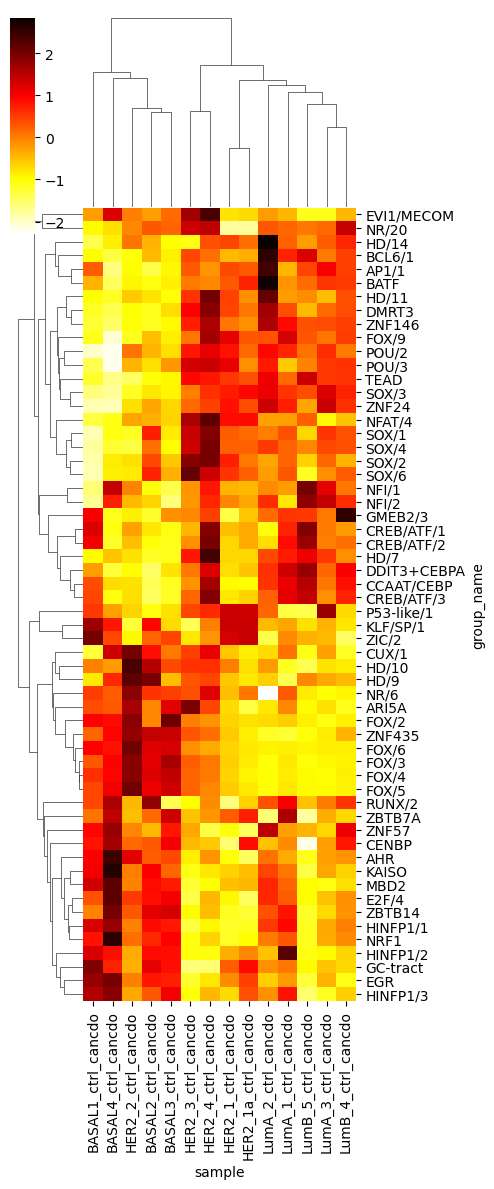

In [39]:
dt = dfplt['df_plot'][['BASAL1_ctrl_cancdo', 'BASAL2_ctrl_cancdo', 'BASAL3_ctrl_cancdo',
       'BASAL4_ctrl_cancdo', 'HER2_2_ctrl_cancdo', 'HER2_1_ctrl_cancdo', 'HER2_1a_ctrl_cancdo', 'HER2_3_ctrl_cancdo', 'HER2_4_ctrl_cancdo',
       'LumA_1_ctrl_cancdo', 'LumA_2_ctrl_cancdo', 'LumA_3_ctrl_cancdo',
       'LumB_4_ctrl_cancdo', 'LumB_5_ctrl_cancdo']]
p = sns.clustermap(dt, xticklabels=True, yticklabels=True, cmap=cmap, 
                   row_cluster=True, col_cluster=True, z_score=None, figsize=(5, 12), )#vmax=3., vmin=-3.)


In [ ]:
# save proper one 
file = '~/tmp/results/reg_diffs/{}_{}_z{}_top{}_drop{}.csv'.format(suffix, subset, zscore_type, n, drop_motif)
print('# pre-z mat:\n  {}\n#pltmat:\n  {}'.format('~/tmp/results/reg_diffs/{}_s{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, subset, zscore_type, n, drop_motif), file))
p.data2d.to_csv(file)

In [42]:
print('# order:')
print(dfplt['df_plot'].index[p.dendrogram_row.reordered_ind].to_list())
print('')
if col_cluster:
    print(dfplt['df_plot'].columns[p.dendrogram_col.reordered_ind].to_list())
else:
    print(dfplt['df_plot'].columns.to_list())

# order:
['EVI1/MECOM', 'NR/20', 'HD/14', 'BCL6/1', 'AP1/1', 'BATF', 'HD/11', 'DMRT3', 'ZNF146', 'FOX/9', 'POU/2', 'POU/3', 'TEAD', 'SOX/3', 'ZNF24', 'NFAT/4', 'SOX/1', 'SOX/4', 'SOX/2', 'SOX/6', 'NFI/1', 'NFI/2', 'GMEB2/3', 'CREB/ATF/1', 'CREB/ATF/2', 'HD/7', 'DDIT3+CEBPA', 'CCAAT/CEBP', 'CREB/ATF/3', 'P53-like/1', 'KLF/SP/1', 'ZIC/2', 'CUX/1', 'HD/10', 'HD/9', 'NR/6', 'ARI5A', 'FOX/2', 'ZNF435', 'FOX/6', 'FOX/3', 'FOX/4', 'FOX/5', 'RUNX/2', 'ZBTB7A', 'ZNF57', 'CENBP', 'AHR', 'KAISO', 'MBD2', 'E2F/4', 'ZBTB14', 'HINFP1/1', 'NRF1', 'HINFP1/2', 'GC-tract', 'EGR', 'HINFP1/3']

['BASAL1_ctrl_cancdo', 'BASAL2_ctrl_cancdo', 'BASAL3_ctrl_cancdo', 'BASAL4_ctrl_cancdo', 'HER2_1_ctrl_cancdo', 'HER2_1a_ctrl_cancdo', 'HER2_2_ctrl_cancdo', 'HER2_3_ctrl_cancdo', 'HER2_4_ctrl_cancdo', 'LumA_1_ctrl_cancdo', 'LumA_2_ctrl_cancdo', 'LumA_3_ctrl_cancdo', 'LumB_4_ctrl_cancdo', 'LumB_5_ctrl_cancdo']


## family name version

### viz

In [9]:
# reload 
upvdo_outfile = '~/tmp/results/reg_diffs/indbrcavctrl_v3_modnames_cnvcrctgt100.csv'
df_mod = pd.read_csv(upvdo_outfile, index_col=0)


In [ ]:
# viz 

# viz doVnot

####################################################
# args
####################################################
export = True
name_key = 'modified_names'
suffix = 'clstrmap_v3_modnames_nobasal5'
grid ={'zscore': ['rowcol',],
      'topn': ['sig_only_ORgt1', ],#'sig_only_top10OR', ],
      'drop': [None, ]}
subsets = {'up': df_mod.loc[[True if 'cancup' in s and '_ctrl_' not in s else False for s in df_mod['sample']]],
          }
           #'do': df_mod.loc[[True if 'cancdo' in s and '_canc_' not in s else False for s in df_mod['sample']]]}
# remove basal 5?
subsets['up'] = subsets['up'].loc[[True if 'BASAL5' not in s else False for s in subsets['up']['sample']]]
# subsets['do'] = subsets['do'].loc[[True if 'BASAL5' not in s else False for s in subsets['do']['sample']]]
col_cluster = False
viz_OR = True
cmap = 'hot_r'
####################################################
figsizes = {'topn_None': (10, 30),
            'topn_10': (10, 14),
            'topn_20': (10, 20),
            'topn_sig_only_top10ORlt1': (5, 12),
            'topn_sig_only_top10ORgt1': (5, 12),
            'topn_sig_only_top5OR': (5, 12),
            'topn_sig_only_top3OR': (5, 10),
            'topn_sig_only_top10OR': (5, 12)}
for n in grid['topn']:
    if 'topn_{}'.format(n) not in figsizes.keys():
        figsizes['topn_{}'.format(n)] = (5, 12) # default

pfp = os.path.join('~/project/reg_diffs/results/tmp/', datetime.datetime.now().strftime('%y%m%d'))
if not os.path.exists(pfp):
    os.makedirs(pfp)

if export:
    print('tmp folder for plots:', pfp)

count = 0
for subset in subsets.keys():
    for zscore_type in grid['zscore']:
        for n in grid['topn']:
            for drop_motif in grid['drop']:
                print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
                dfplt, p = mtfcmp.viz_mtfcmp(
                    subsets[subset], 
                    name_key=name_key, 
                    names2display=None,
                    topn=n,
                    fillna=True,
                    viz_OR=viz_OR,
                    drop=drop_motif,
                    cmap=cmap,
                    zscore=zscore_type,
                    save_plot=None if not export else os.path.join(pfp, '{}_{}_z{}_top{}_drop{}.pdf'.format(suffix, subset, zscore_type, n, drop_motif)),
                    save_mat=None if not export else '~/tmp/results/reg_diffs/{}_{}_z{}_top{}_drop{}.csv'.format(suffix, subset, zscore_type, n, drop_motif),
                    return_plot_obj=True,
                    col_cluster=col_cluster,
                    figsize_wh=figsizes['topn_{}'.format(n)],
                )
                if export:
                    dfplt['df_prez'].to_csv('~/tmp/results/reg_diffs/{}_s{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, subset, zscore_type, n, drop_motif))
                    print('  wrote prez-mat: {}'.format('~/tmp/results/reg_diffs/{}_s{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, subset, zscore_type, n, drop_motif)))
                    print('  wrote pltmat: ~/tmp/results/reg_diffs/{}_{}_z{}_top{}_drop{}.csv'.format(suffix, subset, zscore_type, n, drop_motif))
                    print('  wrote plot: {}'.format(os.path.join(pfp, '{}_{}_z{}_top{}_drop{}.pdf'.format(suffix, subset, zscore_type, n, drop_motif))))
                count+=1

In [87]:
print(dfplt['df_plot'].index[p.dendrogram_row.reordered_ind].to_list())
if col_cluster:
    print(dfplt['df_plot'].columns[p.dendrogram_col.reordered_ind].to_list())
else:
    print(dfplt['df_plot'].columns.to_list())

['ZNF384', 'CACCTG/Ebox', 'SNAI', 'OCT4', 'MTF', 'NR2E', 'LEF/TCF', 'EVI1/MECOM', 'GATA', 'CUX', 'FOX', 'LIN5', 'ARI', 'POU', 'NFI', 'TFAP2', 'AHR', 'HIF', 'AP1', 'BAT', 'NFKB', 'REL', 'GRH', 'P53-like', 'HSFY', 'SPZ', 'GMEB2', 'ATF/CREB', 'GFI', 'CCAAT/CEBP', 'DDIT', 'SRF', 'SOX', 'MEF', 'TAT', 'CPEB', 'NFAT', 'YY1', 'SPI', 'DMRT', 'TEA', 'HSF', 'BCL6', 'STAT', 'PLAG', 'HEN', 'OSR', 'CTCF', 'CEN', 'HINFP1', 'KAI', 'NRF', 'MECP', 'MBD', 'ZFX', 'E2F', 'EGR', 'GC-', 'KLF/SP', 'MFZ', 'ZIC']
['BASAL1_canc_cancup', 'BASAL2_canc_cancup', 'BASAL3_canc_cancup', 'BASAL4_canc_cancup', 'HER2_1_canc_cancup', 'HER2_1a_canc_cancup', 'HER2_2_canc_cancup', 'HER2_3_canc_cancup', 'HER2_4_canc_cancup', 'LumA_1_canc_cancup', 'LumA_2_canc_cancup', 'LumA_3_canc_cancup', 'LumB_4_canc_cancup', 'LumB_5_canc_cancup']


In [ ]:
# viz 

# viz doVnot

####################################################
# args
####################################################
export = True
name_key = 'modified_names'
suffix = 'clstrmap_v3_modnames_nobasal5'
grid ={'zscore': ['rowcol',],
      'topn': ['sig_only_ORgt1'],#'sig_only_top10OR', ],
      'drop': [None, ]}
subsets = {#'up': df_mod.loc[[True if 'cancup' in s and '_ctrl_' not in s else False for s in df_mod['sample']]],
          'do': df_mod.loc[[True if 'cancdo' in s and '_canc_' not in s else False for s in df_mod['sample']]]}
# remove basal 5?
# subsets['up'] = subsets['up'].loc[[True if 'BASAL5' not in s else False for s in subsets['up']['sample']]]
subsets['do'] = subsets['do'].loc[[True if 'BASAL5' not in s else False for s in subsets['do']['sample']]]
col_cluster = False
viz_OR = True
cmap = 'hot_r'
####################################################
figsizes = {'topn_None': (10, 30),
            'topn_10': (10, 14),
            'topn_20': (10, 20),
            'topn_sig_only_top10ORlt1': (5, 12),
            'topn_sig_only_top10ORgt1': (5, 12),
            'topn_sig_only_top5OR': (5, 12),
            'topn_sig_only_top3OR': (5, 10),
            'topn_sig_only_top10OR': (5, 12)}
for n in grid['topn']:
    if 'topn_{}'.format(n) not in figsizes.keys():
        figsizes['topn_{}'.format(n)] = (5, 12) # default

pfp = os.path.join('~/project/reg_diffs/results/tmp/', datetime.datetime.now().strftime('%y%m%d'))
if not os.path.exists(pfp):
    os.makedirs(pfp)

if export:
    print('tmp folder for plots:', pfp)

count = 0
for subset in subsets.keys():
    for zscore_type in grid['zscore']:
        for n in grid['topn']:
            for drop_motif in grid['drop']:
                print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
                dfplt, p = mtfcmp.viz_mtfcmp(
                    subsets[subset], 
                    name_key=name_key, 
                    names2display=None,
                    topn=n,
                    fillna=True,
                    viz_OR=viz_OR,
                    drop=drop_motif,
                    cmap=cmap,
                    zscore=zscore_type,
                    save_plot=None if not export else os.path.join(pfp, '{}_{}_z{}_top{}_drop{}.pdf'.format(suffix, subset, zscore_type, n, drop_motif)),
                    save_mat=None if not export else '~/tmp/results/reg_diffs/{}_{}_z{}_top{}_drop{}.csv'.format(suffix, subset, zscore_type, n, drop_motif),
                    return_plot_obj=True,
                    col_cluster=col_cluster,
                    figsize_wh=figsizes['topn_{}'.format(n)],
                )
                if export:
                    dfplt['df_prez'].to_csv('~/tmp/results/reg_diffs/{}_s{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, subset, zscore_type, n, drop_motif))
                    print('  wrote prez-mat: {}'.format('~/tmp/results/reg_diffs/{}_s{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, subset, zscore_type, n, drop_motif)))
                    print('  wrote pltmat: ~/tmp/results/reg_diffs/{}_{}_z{}_top{}_drop{}.csv'.format(suffix, subset, zscore_type, n, drop_motif))
                    print('  wrote plot: {}'.format(os.path.join(pfp, '{}_{}_z{}_top{}_drop{}.pdf'.format(suffix, subset, zscore_type, n, drop_motif))))
                count+=1

In [89]:
print(dfplt['df_plot'].index[p.dendrogram_row.reordered_ind].to_list())
if col_cluster:
    print(dfplt['df_plot'].columns[p.dendrogram_col.reordered_ind].to_list())
else:
    print(dfplt['df_plot'].columns.to_list())

['OSR', 'HIF', 'ATF/CREB', 'GMEB2', 'ZBED', 'CCAAT/CEBP', 'DDIT', 'HSFY', 'NR2E', 'NFI', 'AP1', 'BAT', 'REL', 'HSF', 'TEA', 'BCL6', 'NFKB', 'SPI', 'MEF', 'TAT', 'DMRT', 'OCT4', 'LEF', 'SOX', 'LEF/TCF', 'ZIM', 'CPEB', 'ZNF384', 'P53-like', 'POU', 'ARI', 'LIN5', 'CTCF', 'MTF', 'CUX', 'FOX', 'AHR', 'EVI1/MECOM', 'GATA', 'MFZ', 'ZIC', 'E2F', 'SREB', 'EGR', 'GC-', 'KLF/SP', 'CEN', 'MBD', 'HINFP1', 'KAI', 'NRF', 'MECP', 'ZFX']
['BASAL1_ctrl_cancdo', 'BASAL2_ctrl_cancdo', 'BASAL3_ctrl_cancdo', 'BASAL4_ctrl_cancdo', 'HER2_1_ctrl_cancdo', 'HER2_1a_ctrl_cancdo', 'HER2_2_ctrl_cancdo', 'HER2_3_ctrl_cancdo', 'HER2_4_ctrl_cancdo', 'LumA_1_ctrl_cancdo', 'LumA_2_ctrl_cancdo', 'LumA_3_ctrl_cancdo', 'LumB_4_ctrl_cancdo', 'LumB_5_ctrl_cancdo']
